# Tolling Agreement Valuation

This notebook demonstrates the valuation of a **Gas-Fired Tolling Agreement** using a standardized Python API backed by a high-performance **Rust** engine.

## 1. Introduction

A tolling agreement is a contract where the buyer (the "Tolling Party") supplies fuel (Natural Gas) to a power plant and receives electricity (Power) in return, paying for the conversion capacity. The plant owner is responsible for the technical operation.

The value of this agreement depends on the **Spark Spread** (the difference between electricity price and the cost of gas required to generate it).

### The Model
We model the asset prices under the risk-neutral measure $\mathbb{Q}$:

*   **Natural Gas ($G_t$):** Geometric Brownian Motion (GBM).
*   **Electricity ($P_t$):** Mean-Reverting Jump Diffusion (MRJD).
*   **Correlation:** The drivers of Gas and Power are correlated with coefficient $\rho$.

### Architecture
We use the **`ValuationModel`** interface (`src/python/interfaces`) which abstracts the underlying calculation engine. In this case, we use `TollingModel`, which delegates the heavy lifting to our optimized Rust library.

In [13]:
import sys
import os
import time
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure we can import from src/python
notebook_dir = Path(os.getcwd())
src_python_dir = notebook_dir.parent
if str(src_python_dir) not in sys.path:
    sys.path.append(str(src_python_dir))

# Import the Model Wrapper
from models.tolling import TollingModel
import tolling_agreement_valuation

# Set plotting style
sns.set_theme(style="whitegrid")

## 2. Data Setup

We load the input parameters and forward curves into Python objects (Dictionaries and DataFrames). This demonstrates the flexibility of the API—it works with in-memory data, not just files.

In [14]:
model_params = tolling_agreement_valuation.ModelParameters(
     sigma_g = 0.4,
    sigma_p =  0.5,
    kappa = 50.0,
    lambda_j = 5.0,
    mu_j = 0.5,
    sigma_j = 0.3,
    rho = 0.6,
    r = 0.02
)
unit_params = [
    tolling_agreement_valuation.UnitParameter(
        heat_rate = 1.67,
        capacity = 400,
        start_up_costs = 15000
    ),
    tolling_agreement_valuation.UnitParameter(
        heat_rate = 3.33,
        capacity = 100,
        start_up_costs = 2000
    ),
]

print("Model Parameters (Rust Object):")
print(f"Sigma G: {model_params.sigma_g}, Sigma P: {model_params.sigma_p}...")

Model Parameters (Rust Object):
Sigma G: 0.4, Sigma P: 0.5...


In [15]:
dates = pd.date_range(
    start="2025-01-01 00:00:00",
    end="2025-12-31 23:00:00",
    freq="H"
)

hours = np.arange(len(dates))
t_years = hours / (365.0 * 24.0)

/var/folders/2f/29kqzy4x6dd04c18ghtnb5tr0000gn/T/ipykernel_5857/644385406.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


In [16]:
base_price_gas = 3.50
seasonality_gas = 0.50

curve = base_price_gas + seasonality_gas * np.sin(2 * np.pi * t_years)
gas_curve =  pd.DataFrame(
        {
            "date": dates,
            "price": curve,
        }
).set_index("date")

In [17]:
base_price_power = 45
seasonality_power = 10

curve = base_price_power + seasonality_power * np.sin(2 * np.pi * t_years)
power_curve = pd.DataFrame(
    {
        "date": dates,
        "price": curve,
    }
).set_index("date")

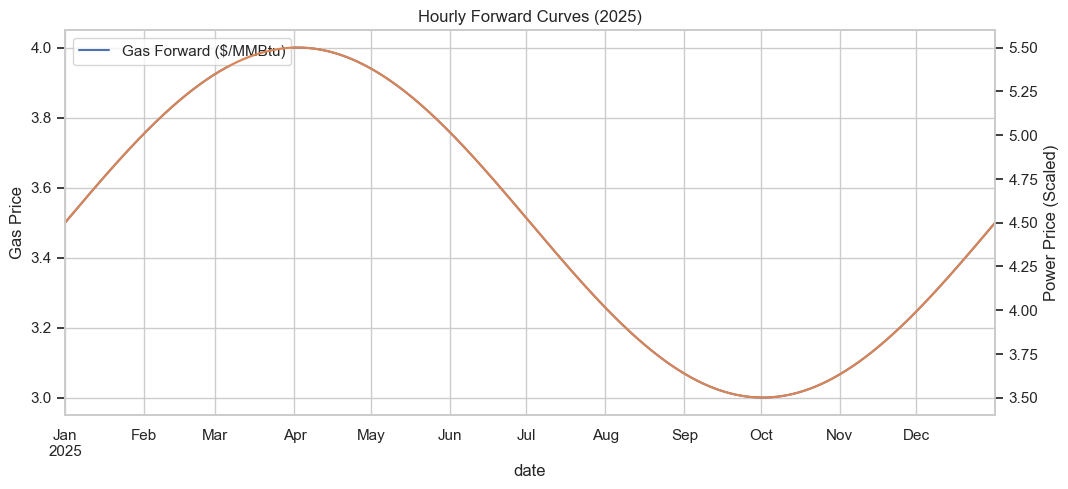

In [18]:
fig, ax = plt.subplots(figsize=(12, 5))
gas_curve['price'].plot(ax=ax, label='Gas Forward ($/MMBtu)')
(power_curve['price'] / 10).plot(ax=ax, label='Power Forward ($/MWh / 10)', secondary_y=True)

ax.set_title("Hourly Forward Curves (2025)")
ax.set_ylabel("Gas Price")
ax.right_ax.set_ylabel("Power Price (Scaled)")
ax.legend(loc='upper left')
plt.show()

## 3. Simulation (via Standard API)

We instantiate the `TollingModel`, load our data, and request sample paths. The model handles the communication with the Rust backend transparently.

In [19]:
# Initialize Model
model = TollingModel()

# Load Data
model.load_parameters(model_params, unit_params)
model.load_forward_curves({
    'gas': gas_curve, 
    'power': power_curve
})

NUM_PATHS = 100_000

start_time = time.time()

# Generate Paths
sim_paths = model.get_sample_paths(NUM_PATHS)

end_time = time.time()
print(f"Simulation of {NUM_PATHS} paths took {end_time - start_time:.4f} seconds.")
print(f"Output Shape: {sim_paths.shape} (Paths, Assets, Hours)")

Simulation of 100000 paths took 4.3795 seconds.
Output Shape: (100000, 2, 8760) (Paths, Assets, Hours)


## 4. Visualization

We visualize the simulated paths to ensure they behave as expected.

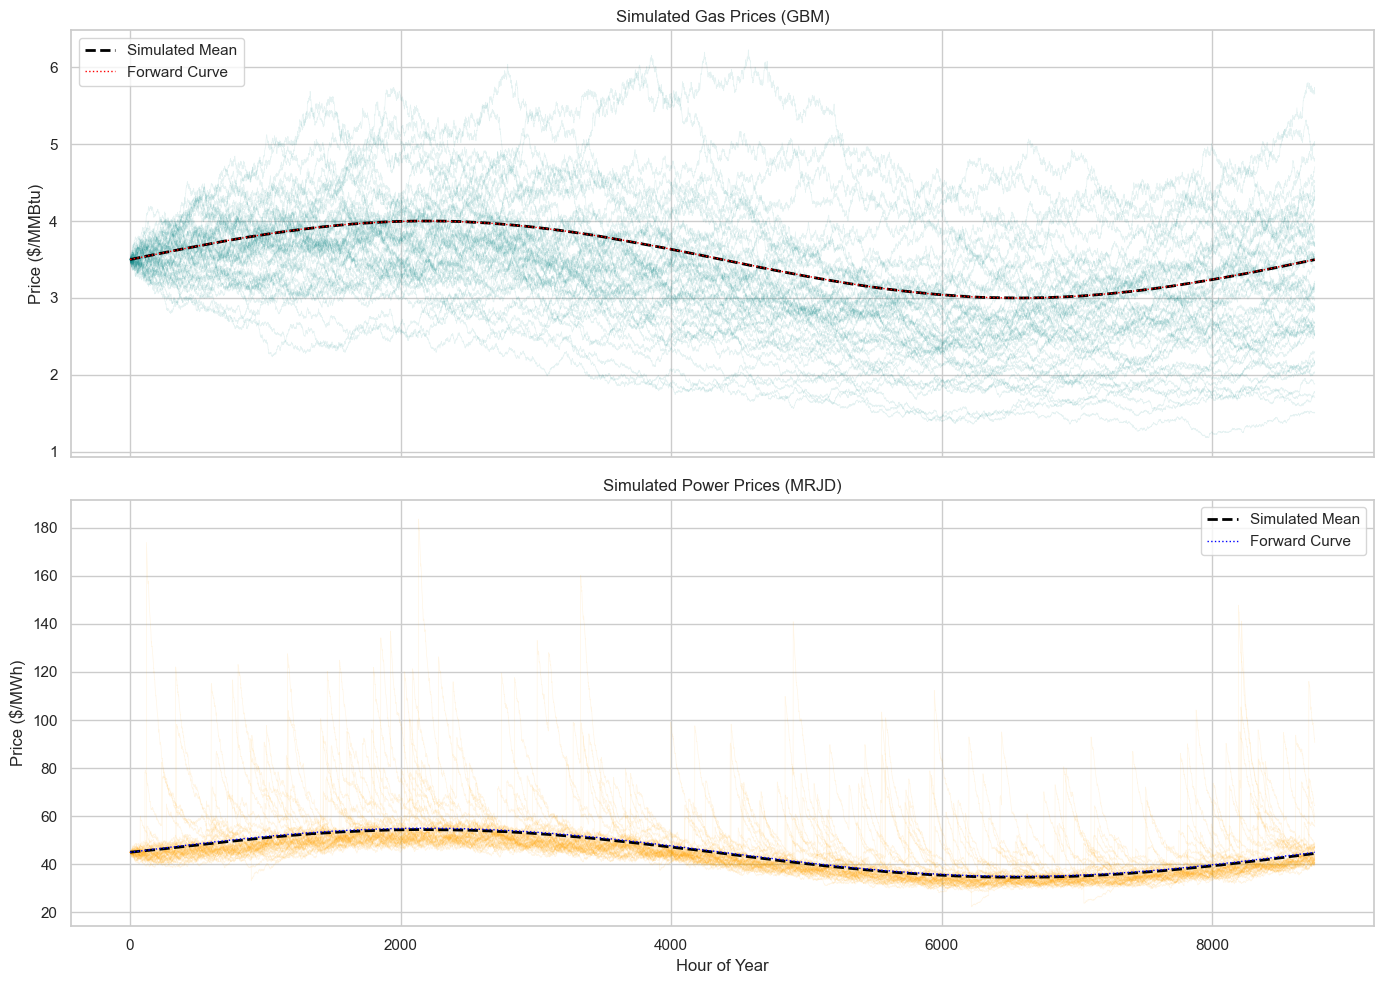

In [20]:
# Extract Gas (index 0) and Power (index 1)
gas_paths = sim_paths[:, 0, :]
power_paths = sim_paths[:, 1, :]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# --- Gas Plot ---
ax1.plot(gas_paths.T[:, :50], color='teal', alpha=0.1, linewidth=0.5)
ax1.plot(gas_paths.mean(axis=0), color='black', linewidth=2, linestyle='--', label='Simulated Mean')
ax1.plot(gas_curve['price'].values, color='red', linewidth=1, linestyle=':', label='Forward Curve')

ax1.set_title("Simulated Gas Prices (GBM)")
ax1.set_ylabel("Price ($/MMBtu)")
ax1.legend()

# --- Power Plot ---
ax2.plot(power_paths.T[:, :50], color='orange', alpha=0.1, linewidth=0.5)
ax2.plot(power_paths.mean(axis=0), color='black', linewidth=2, linestyle='--', label='Simulated Mean')
ax2.plot(power_curve['price'].values, color='blue', linewidth=1, linestyle=':', label='Forward Curve')

ax2.set_title("Simulated Power Prices (MRJD)")
ax2.set_ylabel("Price ($/MWh)")
ax2.set_xlabel("Hour of Year")
ax2.legend()

plt.tight_layout()
plt.show()

## 5. Valuation

We calculate the Net Present Value (NPV).

In [21]:
VALUATION_PATHS = 10_000

print(f"Calculating NPV with {VALUATION_PATHS} paths...")
start_time = time.time()

npv = model.calculate_npv(VALUATION_PATHS)

end_time = time.time()

print(f"Calculation took {end_time - start_time:.4f} seconds.")
print(f"------------------------------------------------")
print(f"Tolling Agreement NPV: €{npv:,.2f}")
print(f"------------------------------------------------")

Calculating NPV with 10000 paths...
Calculation took 0.4153 seconds.
------------------------------------------------
Tolling Agreement NPV: €156,683,751.64
------------------------------------------------


## 6. Convergence Analysis

Checking stability with respect to the number of paths.

N=100: €157,014,161.14 (0.004s)
N=500: €156,523,660.91 (0.021s)
N=1000: €156,655,643.56 (0.040s)
N=5000: €156,809,941.87 (0.172s)
N=10000: €156,640,698.91 (0.330s)
N=20000: €156,619,839.52 (2.274s)


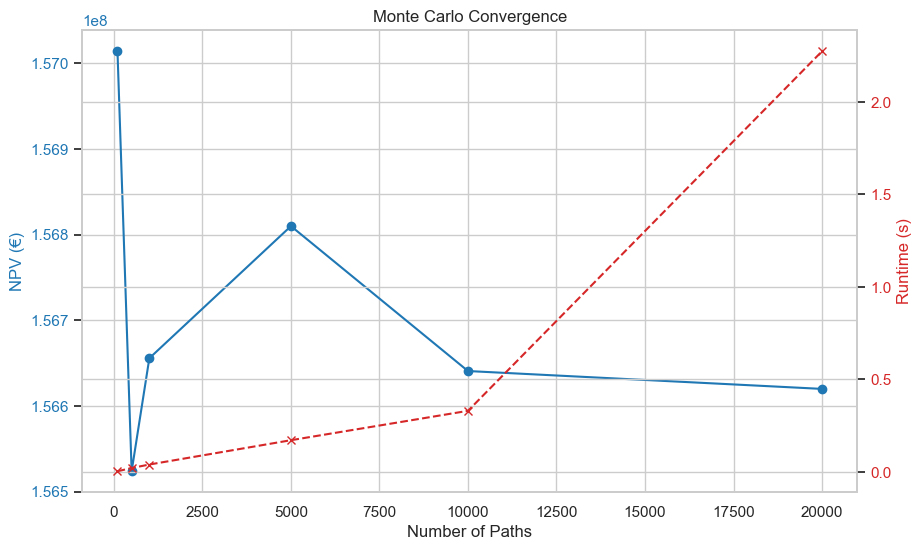

In [22]:
path_counts = [100, 500, 1000, 5000, 10000, 20000]
results = []
times = []

for n in path_counts:
    t0 = time.time()
    val = model.calculate_npv(n)
    t1 = time.time()
    results.append(val)
    times.append(t1 - t0)
    print(f"N={n}: €{val:,.2f} ({t1-t0:.3f}s)")

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(path_counts, results, marker='o', color='tab:blue', label='NPV Estimate')
ax1.set_xlabel('Number of Paths')
ax1.set_ylabel('NPV (€)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_title("Monte Carlo Convergence")

ax2 = ax1.twinx()
ax2.plot(path_counts, times, marker='x', color='tab:red', linestyle='--', label='Runtime')
ax2.set_ylabel('Runtime (s)', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.show()